# Chapter 7 航空公司客户价值分析

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
data=pd.read_csv('../data/chapter7.csv')
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/2,2008/12/24,男,6,.,北京,CN,31.0,2014/3/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/2/19,2007/8/3,男,6,NaN,北京,CN,42.0,2014/3/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/2/1,2007/8/30,男,6,.,北京,CN,40.0,2014/3/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/8/22,2008/8/23,男,5,Los Angeles,CA,US,64.0,2014/3/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/4/10,2009/4/15,男,6,贵阳,贵州,CN,48.0,2014/3/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


In [3]:
# 包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）
explore = data.describe(percentiles = [], include = 'all').T  # T是转置，转置后更方便查阅
explore['null'] = len(data)-explore['count']  # describe()函数自动计算非空值数，需要手动计算空值数

explore = explore[['null', 'max', 'min']]
explore.columns = ['空值数', '最大值', '最小值']  # 表头重命名
'''
这里只选取部分探索结果。
describe()函数自动计算的字段有count（非空值数）、unique（唯一值数）、top（频数最高者）、
freq（最高频数）、mean（平均值）、std（方差）、min（最小值）、50%（中位数）、max（最大值）
'''
explore.to_csv('../data/chapter7_describe.csv')  # 导出结果
explore

,空值数,最大值,最小值
MEMBER_NO,0.0,62988.0,1.0
FFP_DATE,0,NaN,NaN
FIRST_FLIGHT_DATE,0,NaN,NaN
GENDER,3,NaN,NaN
FFP_TIER,0.0,6.0,4.0
WORK_CITY,2269,NaN,NaN
WORK_PROVINCE,3248,NaN,NaN
WORK_COUNTRY,26,NaN,NaN
AGE,420.0,110.0,6.0
LOAD_TIME,0,NaN,NaN


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDE

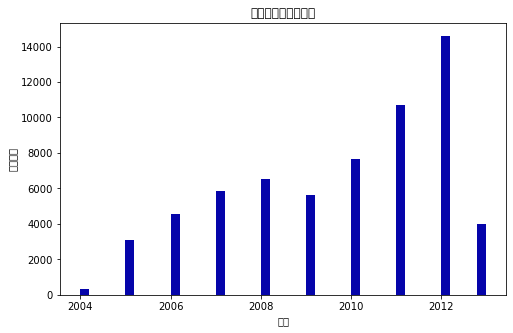

<function matplotlib.pyplot.close(fig=None)>

In [5]:
# 客户信息类别
# 提取会员入会年份
ffp = data['FFP_DATE'].apply(lambda x:datetime.strptime(x,'%Y/%m/%d'))
ffp_year = ffp.map(lambda x : x.year)
# 绘制各年份会员入会人数直方图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置中文显示
plt.rcParams['axes.unicode_minus'] = False
plt.hist(ffp_year, bins='auto', color='#0504aa')
plt.xlabel('年份')
plt.ylabel('入会人数')
plt.title('各年份会员入会人数')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

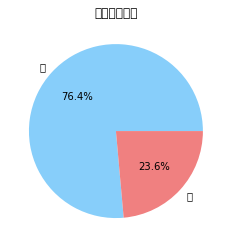

<function matplotlib.pyplot.close(fig=None)>

In [6]:
# 提取会员不同性别人数
male = pd.value_counts(data['GENDER'])['男']
female = pd.value_counts(data['GENDER'])['女']
# 绘制会员性别比例饼图
fig = plt.figure(figsize = (7 ,4))  # 设置画布大小
plt.pie([ male, female], labels=['男','女'], colors=['lightskyblue', 'lightcoral'],
       autopct='%1.1f%%')
plt.title('会员性别比例')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

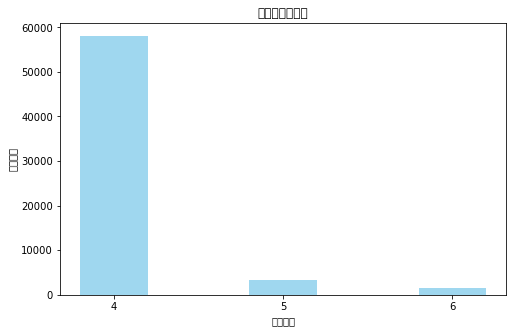

In [8]:
# 提取不同级别会员的人数
lv_four = pd.value_counts(data['FFP_TIER'])[4]
lv_five = pd.value_counts(data['FFP_TIER'])[5]
lv_six = pd.value_counts(data['FFP_TIER'])[6]
# 绘制会员各级别人数条形图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.bar(x=range(3), height=[lv_four,lv_five,lv_six], width=0.4, alpha=0.8, color='skyblue')
plt.xticks([index for index in range(3)], ['4','5','6'])
plt.xlabel('会员等级')
plt.ylabel('会员人数')
plt.title('会员各级别人数')
plt.show()
plt.close()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40836 (\N{CJK UNIFIED IDEOGRAPH-9F84}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

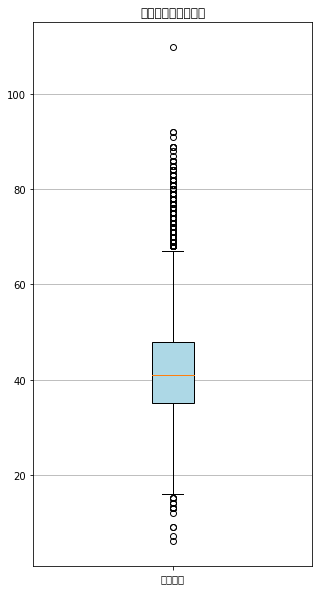

<function matplotlib.pyplot.close(fig=None)>

In [9]:
# 提取会员年龄
age = data['AGE'].dropna()
age = age.astype('int64')
# 绘制会员年龄分布箱型图
fig = plt.figure(figsize = (5 ,10))
plt.boxplot(age,
            patch_artist=True,
            labels = ['会员年龄'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员年龄分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

In [10]:
# 乘机信息类别
lte = data['LAST_TO_END']
fc = data['FLIGHT_COUNT']
sks = data['SEG_KM_SUM']

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

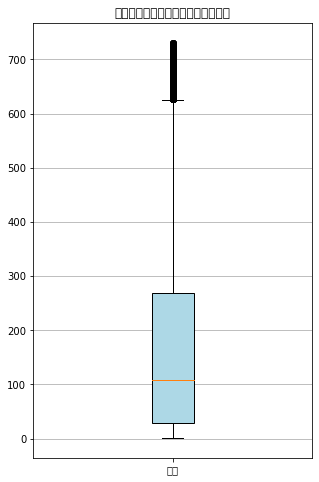

<function matplotlib.pyplot.close(fig=None)>

In [11]:
# 绘制最后乘机至结束时长箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(lte,
            patch_artist=True,
            labels = ['时长'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员最后乘机至结束时长分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

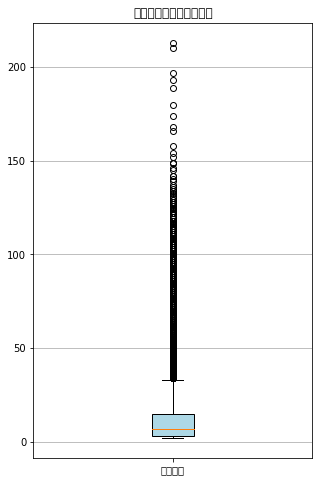

<function matplotlib.pyplot.close(fig=None)>

In [12]:
# 绘制客户飞行次数箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(fc,
            patch_artist=True,
            labels = ['飞行次数'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('会员飞行次数分布箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

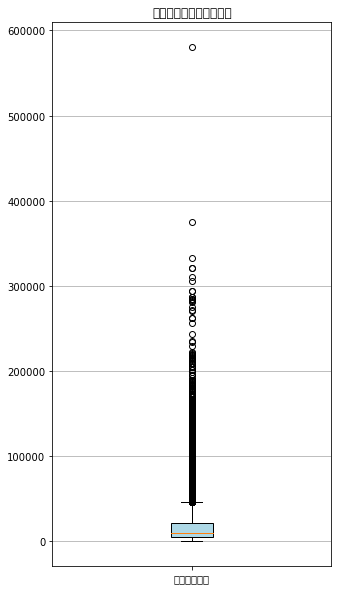

<function matplotlib.pyplot.close(fig=None)>

In [13]:
# 绘制客户总飞行公里数箱线图
fig = plt.figure(figsize = (5 ,10))
plt.boxplot(sks,
            patch_artist=True,
            labels = ['总飞行公里数'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('客户总飞行公里数箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F1A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21592 (\N{CJK UNIFIED IDEOGRAPH-5458}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20817 (\N{CJK UNIFIED IDEOGRAPH-5151}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25442 (\N{CJK UNIFIED IDEOGRAPH-6362}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

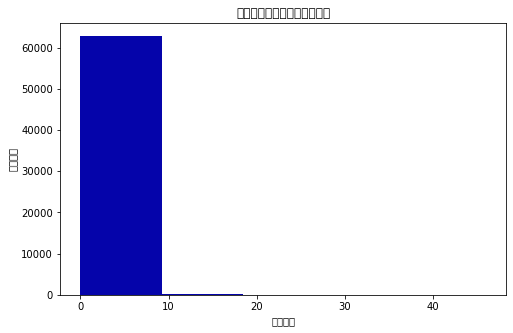

<function matplotlib.pyplot.close(fig=None)>

In [14]:
# 积分信息类别
# 提取会员积分兑换次数
ec = data['EXCHANGE_COUNT']
# 绘制会员兑换积分次数直方图
fig = plt.figure(figsize = (8 ,5))  # 设置画布大小
plt.hist(ec, bins=5, color='#0504aa')
plt.xlabel('兑换次数')
plt.ylabel('会员人数')
plt.title('会员兑换积分次数分布直方图')
plt.show()
plt.close

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

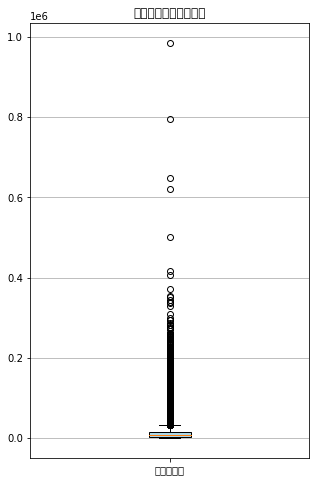

<function matplotlib.pyplot.close(fig=None)>

In [15]:
# 提取会员总累计积分
ps = data['Points_Sum']
# 绘制会员总累计积分箱线图
fig = plt.figure(figsize = (5 ,8))
plt.boxplot(ps,
            patch_artist=True,
            labels = ['总累计积分'],  # 设置x轴标题
            boxprops = {'facecolor':'lightblue'})  # 设置填充颜色
plt.title('客户总累计积分箱线图')
# 显示y坐标轴的底线
plt.grid(axis='y')
plt.show()
plt.close

In [16]:
# 提取属性并合并为新数据集
data_corr = data[['FFP_TIER','FLIGHT_COUNT','LAST_TO_END',
                  'SEG_KM_SUM','EXCHANGE_COUNT','Points_Sum']]
age1 = data['AGE'].fillna(0)
data_corr['AGE'] = age1.astype('int64')
data_corr['ffp_year'] = ffp_year

/var/folders/bm/p1mqyz457mdgdtmf_f3vhx6m0000gn/T/ipykernel_4138/3128995994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr['AGE'] = age1.astype('int64')
/var/folders/bm/p1mqyz457mdgdtmf_f3vhx6m0000gn/T/ipykernel_4138/3128995994.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_corr['ffp_year'] = ffp_year


In [17]:
# 计算相关性矩阵
dt_corr = data_corr.corr(method = 'pearson')
print('相关性矩阵为：\n',dt_corr)

相关性矩阵为：
                 FFP_TIER  FLIGHT_COUNT  LAST_TO_END  SEG_KM_SUM  \
FFP_TIER        1.000000      0.582447    -0.206313    0.522350   
FLIGHT_COUNT    0.582447      1.000000    -0.404999    0.850411   
LAST_TO_END    -0.206313     -0.404999     1.000000   -0.369509   
SEG_KM_SUM      0.522350      0.850411    -0.369509    1.000000   
EXCHANGE_COUNT  0.342355      0.502501    -0.169717    0.507819   
Points_Sum      0.559249      0.747092    -0.292027    0.853014   
AGE             0.076245      0.075309    -0.027654    0.087285   
ffp_year       -0.116510     -0.188181     0.117913   -0.171508   

                EXCHANGE_COUNT  Points_Sum       AGE  ffp_year  
FFP_TIER              0.342355    0.559249  0.076245 -0.116510  
FLIGHT_COUNT          0.502501    0.747092  0.075309 -0.188181  
LAST_TO_END          -0.169717   -0.292027 -0.027654  0.117913  
SEG_KM_SUM            0.507819    0.853014  0.087285 -0.171508  
EXCHANGE_COUNT        1.000000    0.578581  0.032760 -0.216610

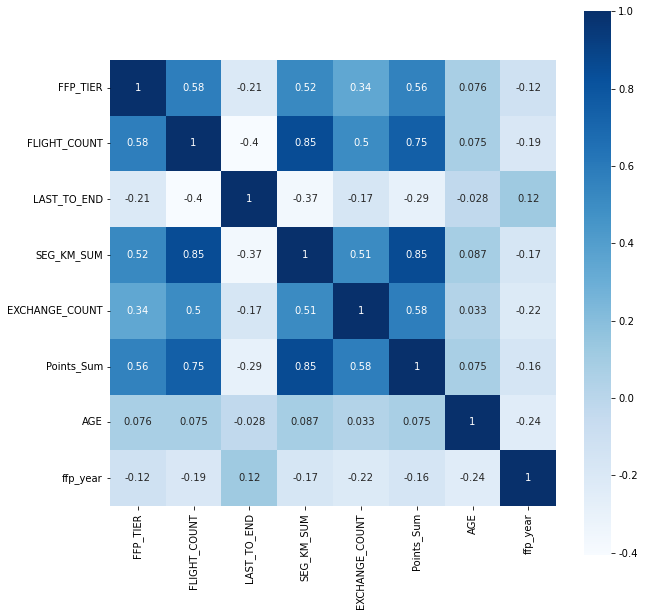

<function matplotlib.pyplot.close(fig=None)>

In [18]:
# 绘制热力图
plt.subplots(figsize=(10, 10)) # 设置画面大小
sns.heatmap(dt_corr, annot=True, vmax=1, square=True, cmap='Blues')
plt.show()
plt.close

In [19]:
# 处理缺失值与异常值

# 原数据
print('原始数据的形状为：',data.shape)

# 去除票价为空的记录
airline_notnull = data.loc[data['SUM_YR_1'].notnull() & data['SUM_YR_2'].notnull(),:]
print('删除缺失记录后数据的形状为：',airline_notnull.shape)

# 只保留票价非零的，或者平均折扣率不为0且总飞行公里数大于0的记录。
index1 = airline_notnull['SUM_YR_1'] != 0
index2 = airline_notnull['SUM_YR_2'] != 0
index3 = (airline_notnull['SEG_KM_SUM']> 0) & (airline_notnull['avg_discount'] != 0)
index4 = airline_notnull['AGE'] > 100  # 去除年龄大于100的记录
airline = airline_notnull[(index1 | index2) & index3 & ~index4]
print('数据清洗后数据的形状为：',airline.shape)

airline.to_csv('../data/cleaned_data.csv')  # 保存清洗后的数据

原始数据的形状为： (62988, 44)
删除缺失记录后数据的形状为： (62299, 44)
数据清洗后数据的形状为： (62043, 44)


In [20]:
# 选取需求属性
airline_selection = airline[['FFP_DATE','LOAD_TIME','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
print('筛选的属性前5行为：\n',airline_selection.head())

筛选的属性前5行为：
     FFP_DATE  LOAD_TIME  LAST_TO_END  FLIGHT_COUNT  SEG_KM_SUM  avg_discount
0  2006/11/2  2014/3/31            1           210      580717      0.961639
1  2007/2/19  2014/3/31            7           140      293678      1.252314
2   2007/2/1  2014/3/31           11           135      283712      1.254676
3  2008/8/22  2014/3/31           97            23      281336      1.090870
4  2009/4/10  2014/3/31            5           152      309928      0.970658


In [21]:
# 构造属性L
L = pd.to_datetime(airline_selection['LOAD_TIME']) - pd.to_datetime(airline_selection['FFP_DATE'])
L = L.astype('str').str.split().str[0]
L = L.astype('int')/30

In [22]:
# 合并属性
airline_features = pd.concat([L,airline_selection.iloc[:,2:]],axis = 1)
airline_features.columns = ['L','R','F','M','C']
print('构建的LRFMC属性前5行为：\n',airline_features.head())

构建的LRFMC属性前5行为：
            L   R    F       M         C
0  90.200000   1  210  580717  0.961639
1  86.566667   7  140  293678  1.252314
2  87.166667  11  135  283712  1.254676
3  68.233333  97   23  281336  1.090870
4  60.533333   5  152  309928  0.970658


In [24]:
# 数据标准化
data = StandardScaler().fit_transform(airline_features)
np.savez('../data/airline_scale.npz',data)
print('标准化后LRFMC五个属性为：\n',data[:5,:])

标准化后LRFMC五个属性为：
 [[ 1.43579256 -0.94493902 14.03402401 26.76115699  1.29554188]
 [ 1.30723219 -0.91188564  9.07321595 13.12686436  2.86817777]
 [ 1.32846234 -0.88985006  8.71887252 12.65348144  2.88095186]
 [ 0.65853304 -0.41608504  0.78157962 12.54062193  1.99471546]
 [ 0.3860794  -0.92290343  9.92364019 13.89873597  1.34433641]]


In [41]:
# K-means聚类
# 读取标准化后的数据
airline_scale = np.load('../data/airline_scale.npz')['arr_0']
airline_scale

array([[ 1.43579256, -0.94493902, 14.03402401, 26.76115699,  1.29554188],
       [ 1.30723219, -0.91188564,  9.07321595, 13.12686436,  2.86817777],
       [ 1.32846234, -0.88985006,  8.71887252, 12.65348144,  2.88095186],
       ...,
       [-0.14939227, -0.73560098, -0.7066628 , -0.77233461, -2.68988313],
       [-1.20618215,  1.60567965, -0.7066628 , -0.77983958, -2.55462608],
       [-0.47963911,  0.60306065, -0.7066628 , -0.78667955, -2.39231762]])

In [42]:
k = 5  # 确定聚类中心数

# 构建模型，随机种子设为123
kmeans_model = KMeans(n_clusters = k,n_init=4,random_state=123)
fit_kmeans = kmeans_model.fit(airline_scale)  # 模型训练

In [43]:
# 查看聚类结果
kmeans_cc = kmeans_model.cluster_centers_  # 聚类中心
print('各类聚类中心为：\n',kmeans_cc)
kmeans_labels = kmeans_model.labels_  # 样本的类别标签
print('各样本的类别标签为：\n',kmeans_labels)
r1 = pd.Series(kmeans_model.labels_).value_counts()  # 统计不同类别样本的数目
print('最终每个类别的数目为：\n',r1)

各类聚类中心为：
 [[ 1.16858148 -0.38005532 -0.08310598 -0.09048484 -0.16482322]
 [-0.70182072 -0.41969421 -0.15465523 -0.15202618 -0.2998482 ]
 [-0.30731409  1.69947472 -0.5752883  -0.53635752 -0.20105777]
 [ 0.48573733 -0.79976463  2.48229556  2.42377224  0.32271572]
 [-0.06479764  0.00270347 -0.269005   -0.28691542  1.907763  ]]
各样本的类别标签为：
 [3 3 3 ... 1 2 2]
最终每个类别的数目为：
 1    23896
0    15534
2    11878
4     5389
3     5346
dtype: int64


In [44]:
# 输出聚类分群的结果
cluster_center = pd.DataFrame(kmeans_model.cluster_centers_,\
             columns = ['ZL','ZR','ZF','ZM','ZC'])   # 将聚类中心放在数据框中
cluster_center.index = pd.DataFrame(kmeans_model.labels_ ).\
                  drop_duplicates().iloc[:,0]  # 将样本类别作为数据框索引
print(cluster_center)

         ZL        ZR        ZF        ZM        ZC
0                                                  
3  1.168581 -0.380055 -0.083106 -0.090485 -0.164823
4 -0.701821 -0.419694 -0.154655 -0.152026 -0.299848
0 -0.307314  1.699475 -0.575288 -0.536358 -0.201058
1  0.485737 -0.799765  2.482296  2.423772  0.322716
2 -0.064798  0.002703 -0.269005 -0.286915  1.907763


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: Us

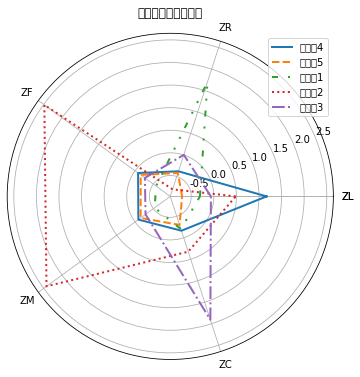

<function matplotlib.pyplot.close(fig=None)>

In [45]:
# 客户分群雷达图
labels = ['ZL','ZR','ZF','ZM','ZC']
legen = ['客户群' + str(i + 1) for i in cluster_center.index]  # 客户群命名，作为雷达图的图例
lstype = ['-','--',(0, (3, 5, 1, 5, 1, 5)),':','-.']
kinds = list(cluster_center.iloc[:, 0])
# 由于雷达图要保证数据闭合，因此再添加L列，并转换为 np.ndarray
cluster_center = pd.concat([cluster_center, cluster_center[['ZL']]], axis=1)
centers = np.array(cluster_center.iloc[:, 0:])

# 分割圆周长，并让其闭合
n = len(labels)
angle = np.linspace(0, 2 * np.pi, n, endpoint=False)
angle = np.concatenate((angle, [angle[0]]))

labels = np.concatenate((labels, [labels[0]]))

# 绘图
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, polar=True)  # 以极坐标的形式绘制图形
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 画线
for i in range(len(kinds)):
    ax.plot(angle, centers[i], linestyle=lstype[i], linewidth=2, label=kinds[i])
# 添加属性标签
ax.set_thetagrids(angle * 180 / np.pi, labels)

plt.title('客户特征分析雷达图')
plt.legend(legen)
plt.show()
plt.close